MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

In [1]:
# for calculating notebook runtime
import time
start_time = time.time()

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

# 1 &nbsp; `Data Exploration (Access, Preprocessimg, and Deriving Features`

Data exploration has been previously explained, discussed, and completed in HW2.  
We are importing this data as explored, cleaned, and prepared with subsets combined.

Standerdize instead of normalize.

In [3]:
excel_file = 'weld_defect_dataset.xlsx'

# gather data from excel file
subsets = []
for i in range(1, 6):
    subset = pd.read_excel(excel_file, sheet_name = 'subset' + str(i))
    subset = subset.rename(columns={'Type':'type','W':'w','Ar':'ar','Sp':'sp','Re':'re','Rr':'rr','Sk':'sk','Ku':'ku','Hc':'hc','Rc':'rc','Sc ':'sc','Kc ':'kc'}) # note the space after Sc and Kc are errors in naming in the excel file and are corrected here for ease of use later
    subsets.append(subset)
df = pd.concat(subsets, ignore_index=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Features
nums = list(df.select_dtypes(include=['float64']).columns)
standard_scaler = MinMaxScaler()
df[nums] = standard_scaler.fit_transform(df[nums])

# Target
types = df['type'].unique().tolist()
print('types:',types)
cat_type = CategoricalDtype(categories=types, ordered=True) # specify the order of categories (stop it from going in alphabetical order; good for confusion matricies comparisons to paper later)
df['type'] = df['type'].astype(cat_type) # convert column to categorical type
df['type_copy'] = df['type'] # create column for get_dummies() to work on so that we keep the orignal 'type' columns afterwards
df = pd.get_dummies(df, columns=['type_copy'], prefix=['type']) # get dummies

excel_file_clean = excel_file.split('.')[0]+'_clean.xlsx'
df.to_excel(excel_file_clean, index=False)
df # clean and prepped dataframe

types: ['PO', 'SL', 'LP', 'LF', 'CR']


,type,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc,type_PO,type_SL,type_LP,type_LF,type_CR
0,PO,0.007173,0.003334,0.548722,0.832328,0.994608,0.090125,0.715208,0.002991,0.107479,0.255421,0.362612,1,0,0,0,0
1,PO,0.008608,0.000000,0.385383,0.832328,0.646705,0.037535,0.297494,0.002672,0.117505,0.331335,0.416629,1,0,0,0,0
2,PO,0.005738,0.000000,0.414137,1.000000,0.751293,0.046435,0.577857,0.002485,0.123983,0.321786,0.417361,1,0,0,0,0
3,PO,0.027259,0.000000,0.286741,0.530516,0.061263,0.243005,0.599790,0.009525,0.088756,0.218969,0.312173,1,0,0,0,0
4,PO,0.017217,0.000000,0.376597,0.552859,0.037085,0.576723,0.446455,0.006427,0.069984,0.269595,0.245306,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,CR,0.276901,0.914287,1.000000,0.101609,0.720118,0.023399,0.289891,0.096535,0.755706,0.230090,0.489335,0,0,0,0,1
215,CR,0.147776,0.693334,0.790735,0.054577,0.507429,0.133745,0.369796,0.010367,0.258734,0.409571,0.503984,0,0,0,0,1
216,CR,0.319942,0.814814,0.683706,0.105508,0.406227,0.025910,0.308671,0.182592,0.755570,0.157137,0.532249,0,0,0,0,1
217,CR,0.321378,0.555773,0.615815,0.142103,0.382799,0.038095,0.313170,0.147628,0.638405,0.217197,0.541198,0,0,0,0,1


For Reference: 

`Defect Features:`

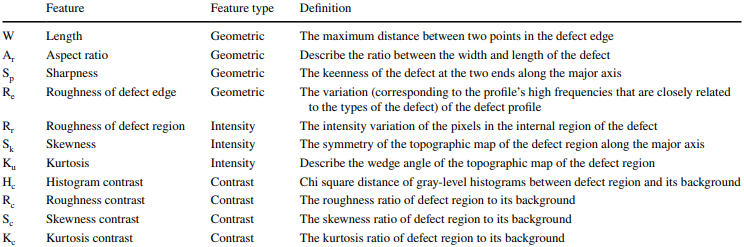

`Defect Types:`  
- `CR` = crack
- `LF` = lack of fusion
- `LP` = lack of penetration
- `PO` = porosity
- `SL` = slag inclusion

Useing `.info()` and `.describe()` for data confirmation and reference:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   type     219 non-null    category
 1   w        219 non-null    float64 
 2   ar       219 non-null    float64 
 3   sp       219 non-null    float64 
 4   re       219 non-null    float64 
 5   rr       219 non-null    float64 
 6   sk       219 non-null    float64 
 7   ku       219 non-null    float64 
 8   hc       219 non-null    float64 
 9   rc       219 non-null    float64 
 10  sc       219 non-null    float64 
 11  kc       219 non-null    float64 
 12  type_PO  219 non-null    uint8   
 13  type_SL  219 non-null    uint8   
 14  type_LP  219 non-null    uint8   
 15  type_LF  219 non-null    uint8   
 16  type_CR  219 non-null    uint8   
dtypes: category(1), float64(11), uint8(5)
memory usage: 20.4 KB


In [5]:
df[nums].describe()


,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.175455,0.198226,0.573799,0.388300,0.248858,0.166017,0.421192,0.088359,0.213025,0.239289,0.451432
std,0.192861,0.248321,0.216306,0.263731,0.208064,0.164301,0.146266,0.132287,0.173836,0.143433,0.151467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035868,0.008612,0.389776,0.129820,0.086887,0.063148,0.339242,0.012170,0.104510,0.144268,0.344502
50%,0.077475,0.057406,0.561102,0.405810,0.213101,0.110880,0.388615,0.032539,0.154791,0.213801,0.455265
75%,0.276901,0.348333,0.800319,0.598214,0.340230,0.198144,0.483941,0.108369,0.250693,0.317586,0.545361
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# sns.pairplot(df, vars=nums, hue='type', diag_kind='kde')

<Axes: >

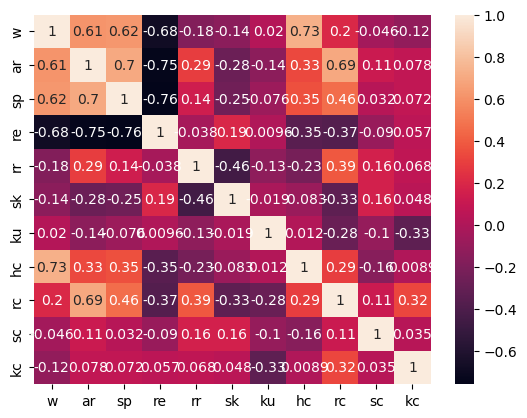

In [7]:
sns.heatmap(df[nums].corr(), annot=True)

# 2 &nbsp; `Train`

We will begin by splitting our data into training and testing sets, using a 20% test size:

In [8]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


Construct basic artificial neural network (ANN) model with Keras:

explain why relu and sigmoid - sigmoid needed for outet - relu needed earlier due to vanishing gradient problem it does best on (as in reaserch paper)

We will create a functioin of a basic ANN model and then created differenent instances basese on different params, skips, etc.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 6)            72          ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 5)            35          ['dense[0][0]']                  
                                                                                                  
 dense_4 (Dense)                (None, 5)            30          ['dense_2[0][0]']                
                                                                                              

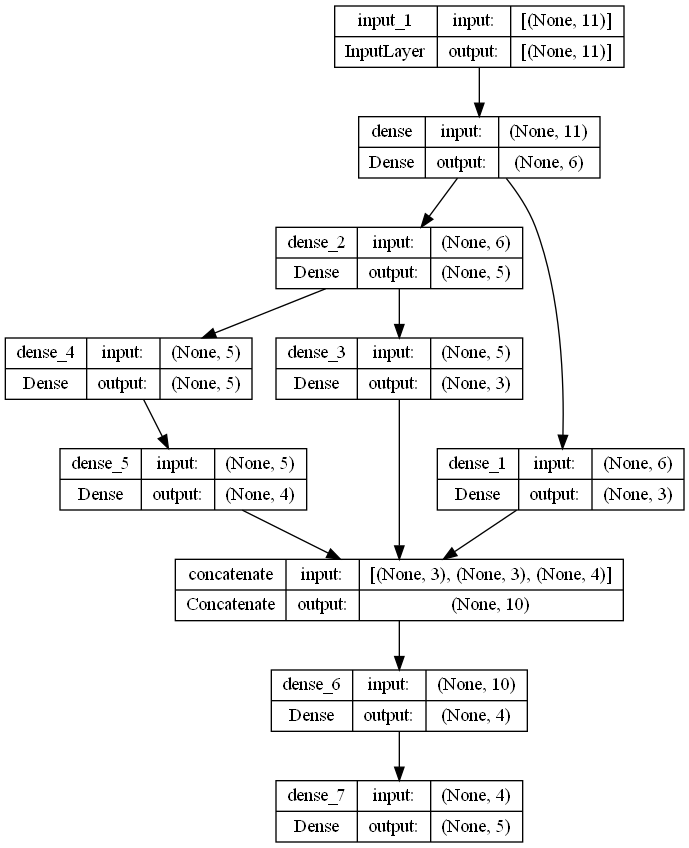

In [9]:
# def create_keras_model(input_dim, output_dim, nodes=5, n_hidden=1, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=1, name='model')
#     '''
#     # Create model
#     model = Sequential(name=name)
#     model.add(Dense(units=nodes,
#                     input_dim=input_dim,
#                     activation='relu',
#                     kernel_initializer='random_normal'
#                    )
#              )
#     # add HIDDEN layers to the network:
#     for i in range(n_hidden):
#         model.add(Dense(units=nodes,
#                         activation='relu',
#                         kernel_initializer='random_normal'
#                        )
#                  )
#     # OUTPUT layer:
#     model.add(Dense(output_dim, 
#                     activation='softmax', #  sigmoid
#                    )
#              )
    
#     model.compile(optimizer='adam', #  sgd
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy']
#                  )
    
#     return model


# def create_keras_model(input_dim, output_dim, nodes=5, n_hidden=4, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=4, name='model')
#     '''

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []

#     # create the hidden layers
#     for i in range(n_hidden):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
#     # create the final hidden layer, connected to all previous hidden layers
#     final_hidden = Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs, name=name)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# def create_keras_model(input_dim=11, output_dim=5, nodes=5, n_hidden=4, name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, nodes=5, n=4, name='model')
#     '''

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []

#     # create the hidden layers
#     for i in range(n_hidden-1):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
#     # create the final hidden layer, connected to all previous hidden layers
#     final_hidden = Dense(units=nodes, activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[5, 10, 15], name='model'):
#     '''
#     How to call:
#     myModel = create_keras_model(n_features, n_classes, hidden_nodes=[5, 10, 15], name='model')
#     '''
#     np.random.seed(42)
#     tf.random.set_seed(42)

#     # define input layer
#     inputs = Input(shape=(input_dim,))

#     # list to hold all the hidden layers
#     hidden_layers = []

#     # create the hidden layers
#     for i in range(len(hidden_nodes)):
#         if i == 0:
#             # if it's the first hidden layer, connect it to the inputs
#             hidden_layers.append(Dense(units=hidden_nodes[i], activation='relu', kernel_initializer='random_normal')(inputs))
#         else:
#             # otherwise, connect it to the previous hidden layer
#             hidden_layers.append(Dense(units=hidden_nodes[i], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
            
#     # create the final hidden layer, connected to all previous hidden layers
#     final_hidden = Dense(units=hidden_nodes[-1], activation='relu', kernel_initializer='random_normal')(concatenate(hidden_layers))

#     # create output layer connected to the final hidden layer
#     outputs = Dense(output_dim, activation='softmax')(final_hidden)

#     # create model
#     model = Model(inputs=inputs, outputs=outputs, name=name)

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# model0 = create_keras_model(n_features, n_classes, hidden_nodes=[6, 5, 5, 10], name='model')
# model0.summary()
# plot_model(model0, show_shapes=True)


# COMPRSSED MODEL

def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[[5, 2], [10, 4], [15, 8]], name='model'):
    '''
    How to call:
    myModel = create_keras_model(n_features, n_classes, hidden_nodes=[[5, 2], [10, 4], [15, 8]], name='model')
    '''

    # define input layer
    inputs = Input(shape=(input_dim,))

    # list to hold all the hidden layers
    hidden_layers = []
    compressed_layers = []

    # create the hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal')(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))
        
        # create compression layer
        compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal')(hidden_layers[-1]))

    # create the final hidden layer, connected to all compression layers
    final_hidden = Dense(units=hidden_nodes[-1][1], activation='relu', kernel_initializer='random_normal')(concatenate(compressed_layers))

    # create output layer connected to the final hidden layer
    outputs = Dense(output_dim, activation='softmax')(final_hidden)

    # create model
    model = Model(inputs=inputs, outputs=outputs, name=name)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model0 = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]], name='model')
model0.summary()
plot_model(model0, show_shapes=True)





In [10]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
# also add regularization in each layer? as seen in image classification notebook?

In [11]:
model0firstfit = model0.fit(X_train, Y_train, batch_size=32, epochs=400, verbose=0, validation_data=(X_test, Y_test))

In [12]:
# model0.metrics_names


# score = model0.evaluate(X_test, Y_test, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])


# fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 8))

# val_accurady = model0firstfit.history['val_accuracy']
# val_loss = model0firstfit.history['val_loss']
# ax1.plot(val_accurady)
# ax2.plot(val_loss)
    
# ax1.set_ylabel('Validation Accuracy')
# ax2.set_ylabel('Validation Loss')
# ax2.set_xlabel('epochs')

(0.0, 1.6897757828235627)

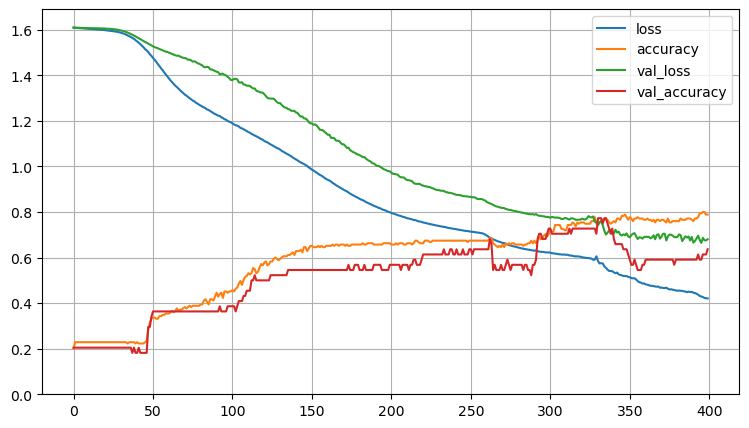

In [13]:
maxes = []
for met in model0firstfit.history.keys():
    maxes.append(max(model0firstfit.history[met]))
mmax = max(maxes)

pd.DataFrame(model0firstfit.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05*mmax) # set the vertical range to [0-1] plt.show()

In [14]:
# # Wrap Keras model with KerasClassifier
# model = KerasClassifier(build_fn=create_keras_model, verbose=0)


# # set parameters
# batch_size = [10, 30]
# epochs = [20, 200]
# param_grid = dict(batch_size=batch_size, epochs=epochs)

# # Create Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
# grid_result = grid.fit(X_train, Y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [15]:
# # create dataframe from cv_results_
# df = pd.DataFrame(grid_result.cv_results_)

# # pivot as prep for heatmap
# df_pivot = df.pivot(index='param_batch_size', columns='param_epochs', values='mean_test_score')

# # create heatmap
# fig, ax = plt.subplots(figsize=(9, 5))
# sns.heatmap(df_pivot, annot=True, cmap="YlGnBu")
# ax.set_title('Accuracy Heatmap')
# ax.set_ylabel('Batch Size')
# ax.set_xlabel('Epochs')

2/2 [==============================] - 0s 3ms/step


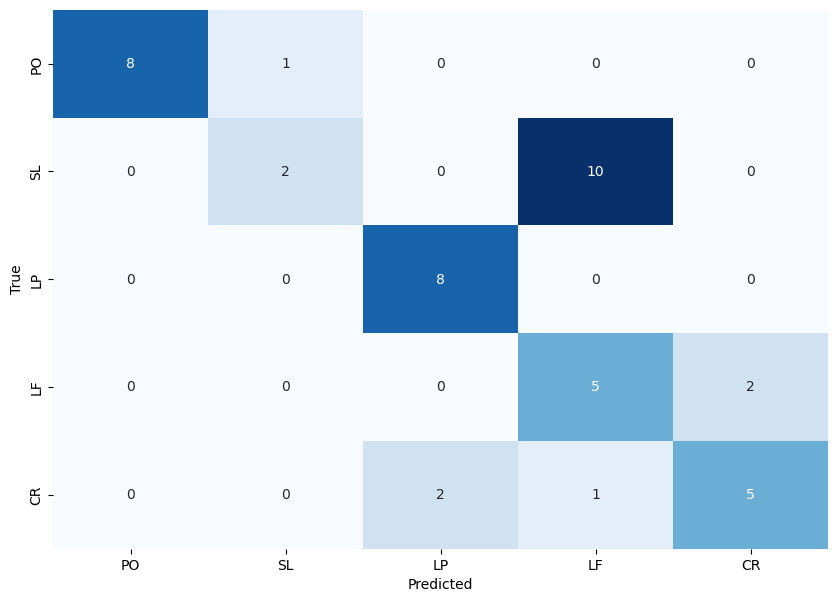

In [16]:
# from sklearn.metrics import accuracy_score

# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict classes for test set
Y_pred = model0.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# convert one-hot encoded test labels back to class labels
y_true = np.argmax(Y_test, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_true, y_pred, target_names=types))

              precision    recall  f1-score   support

          PO       1.00      0.89      0.94         9
          SL       0.67      0.17      0.27        12
          LP       0.80      1.00      0.89         8
          LF       0.31      0.71      0.43         7
          CR       0.71      0.62      0.67         8

    accuracy                           0.64        44
   macro avg       0.70      0.68      0.64        44
weighted avg       0.71      0.64      0.62        44



In [18]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 0.50 minutes.
